In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: set matplotlib inline if using a Jupyter Notebook
%matplotlib inline

In [16]:
df = pd.read_csv('api_data/aggregated_measurements.csv')

df.set_index("Hour", inplace= True)
df.index = pd.to_datetime(df.index)

df['Total_consumption'] = df['Grid Organi lbc']

df = df.drop('Chargers achteraan', axis=1)
df = df.drop('Solar', axis=1)
df = df.drop('Chargers', axis=1)
df = df.drop('Grid Organi lbc', axis=1)

df

,Total_consumption
Hour,
2022-09-28 12:00:00,9.0010
2022-09-28 13:00:00,20.3787
2022-09-28 14:00:00,20.5578
2022-09-28 15:00:00,19.3390
2022-09-28 16:00:00,18.7600
...,...
2025-02-19 08:00:00,71.7051
2025-02-19 09:00:00,130.2653
2025-02-19 10:00:00,119.1813


In [18]:
be_holidays = holidays.BE() 

def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_festive'] = df.index.to_series().apply(lambda x: 1 if x in be_holidays else 0)
    df['working_hour'] = df['hour'].apply(lambda x: 1 if 8 <= x <= 18 else 0)
    df['is_summer'] = df.index.month.isin([6, 7, 8]).astype(int)
    df['is_winter'] = df.index.month.isin([12, 1, 2]).astype(int)

    return df

df = create_features(df)
df

,Total_consumption,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,is_festive,working_hour,is_summer,is_winter
Hour,,,,,,,,,,,,,,
2022-09-28 12:00:00,9.0010,12,2,3,9,2022,271,28,39,0,0,1,0,0
2022-09-28 13:00:00,20.3787,13,2,3,9,2022,271,28,39,0,0,1,0,0
2022-09-28 14:00:00,20.5578,14,2,3,9,2022,271,28,39,0,0,1,0,0
2022-09-28 15:00:00,19.3390,15,2,3,9,2022,271,28,39,0,0,1,0,0
2022-09-28 16:00:00,18.7600,16,2,3,9,2022,271,28,39,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-19 08:00:00,71.7051,8,2,1,2,2025,50,19,8,0,0,1,0,1
2025-02-19 09:00:00,130.2653,9,2,1,2,2025,50,19,8,0,0,1,0,1
2025-02-19 10:00:00,119.1813,10,2,1,2,2025,50,19,8,0,0,1,0,1


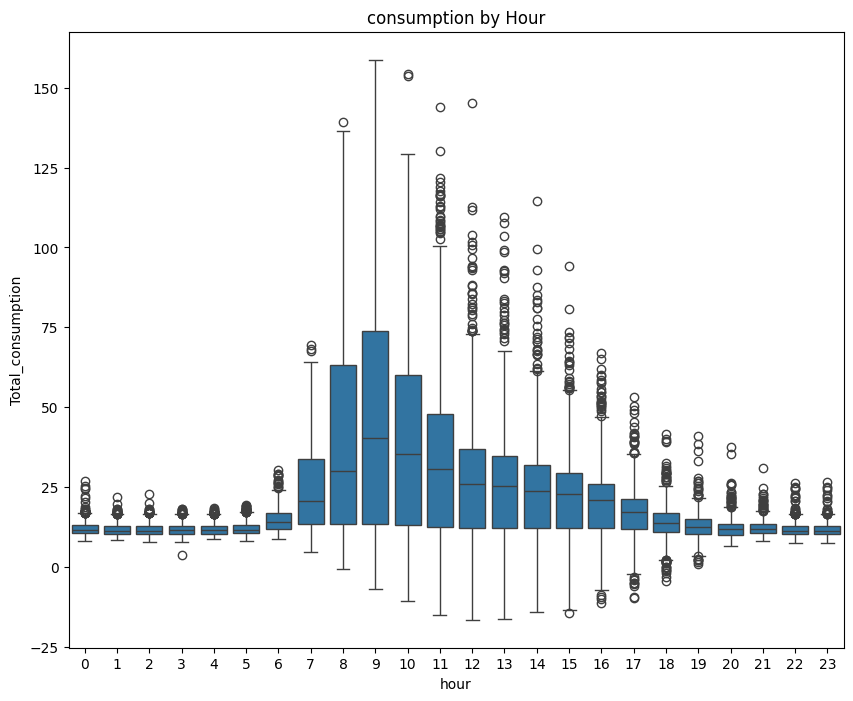

In [19]:
# visualize the hourly Megawatt
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Total_consumption')
ax.set_title('consumption by Hour')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_10532\46599113.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Total_consumption', palette='Blues')


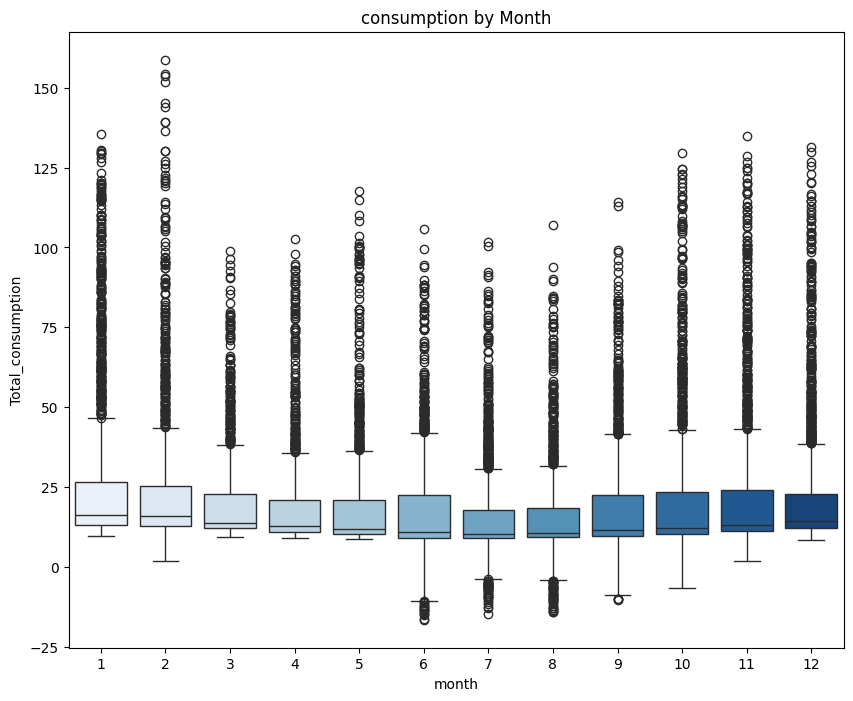

In [20]:
# viaualize the monthly Megawatt
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Total_consumption', palette='Blues')
ax.set_title('consumption by Month')
plt.show()

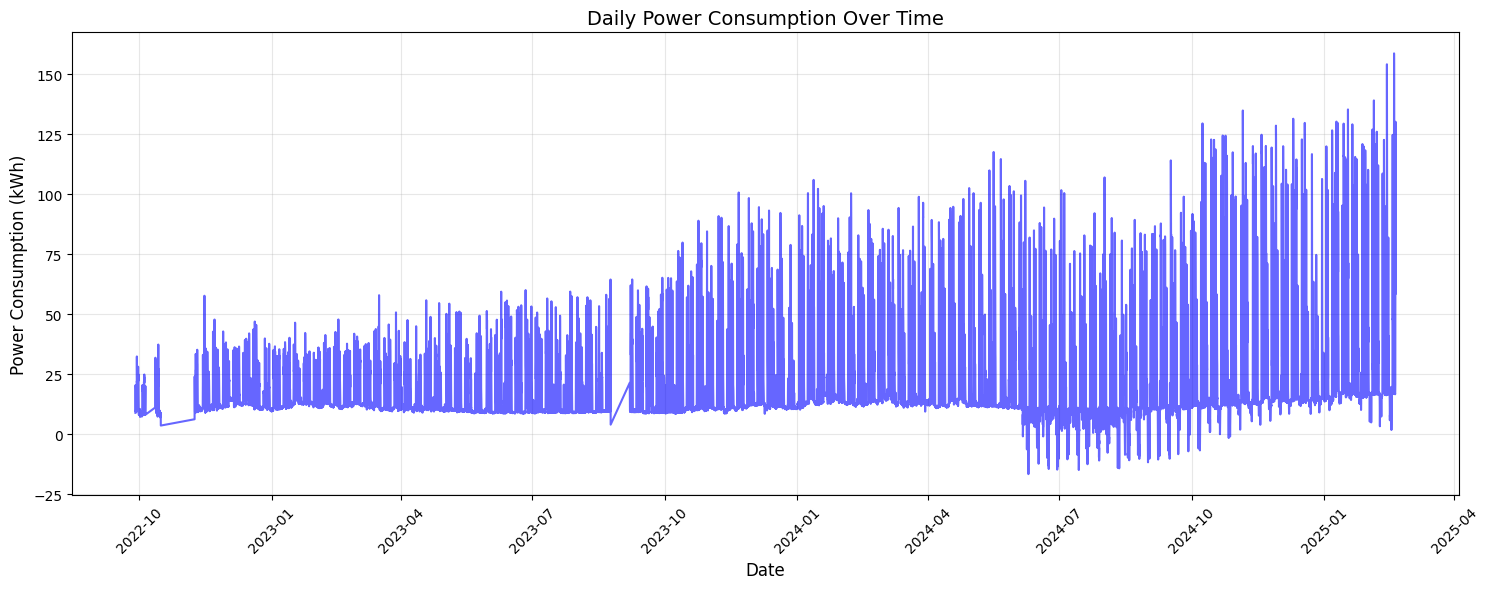

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Total_consumption'], color='blue', alpha=0.6)
plt.title('Daily Power Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
target = "Total_consumption"

exog_features = [
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "is_weekend",
    "is_festive",
    "working_hour",
    "is_summer",
    "is_winter"
]

y = df[target]
exog = df[exog_features]


<Figure size 1000x600 with 0 Axes>

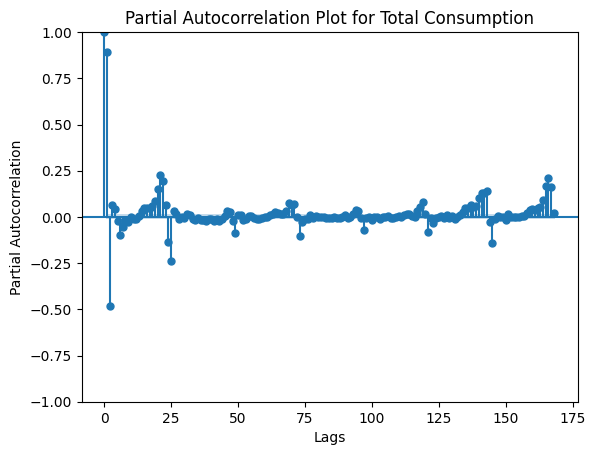

In [52]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Assume y is your target time series, e.g., from your dataframe:
y = df["Total_consumption"]

# Plot the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(y, lags=168, method='ywm')  # Adjust the number of lags as needed
plt.title("Partial Autocorrelation Plot for Total Consumption")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation")
plt.show()

df

<Figure size 1000x600 with 0 Axes>

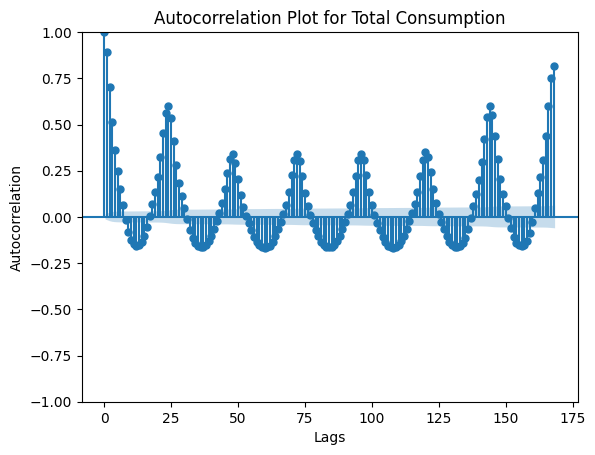

In [54]:
plt.figure(figsize=(10, 6))
plot_acf(y, lags=168)  # Adjust the lags as needed for your data
plt.title("Autocorrelation Plot for Total Consumption")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

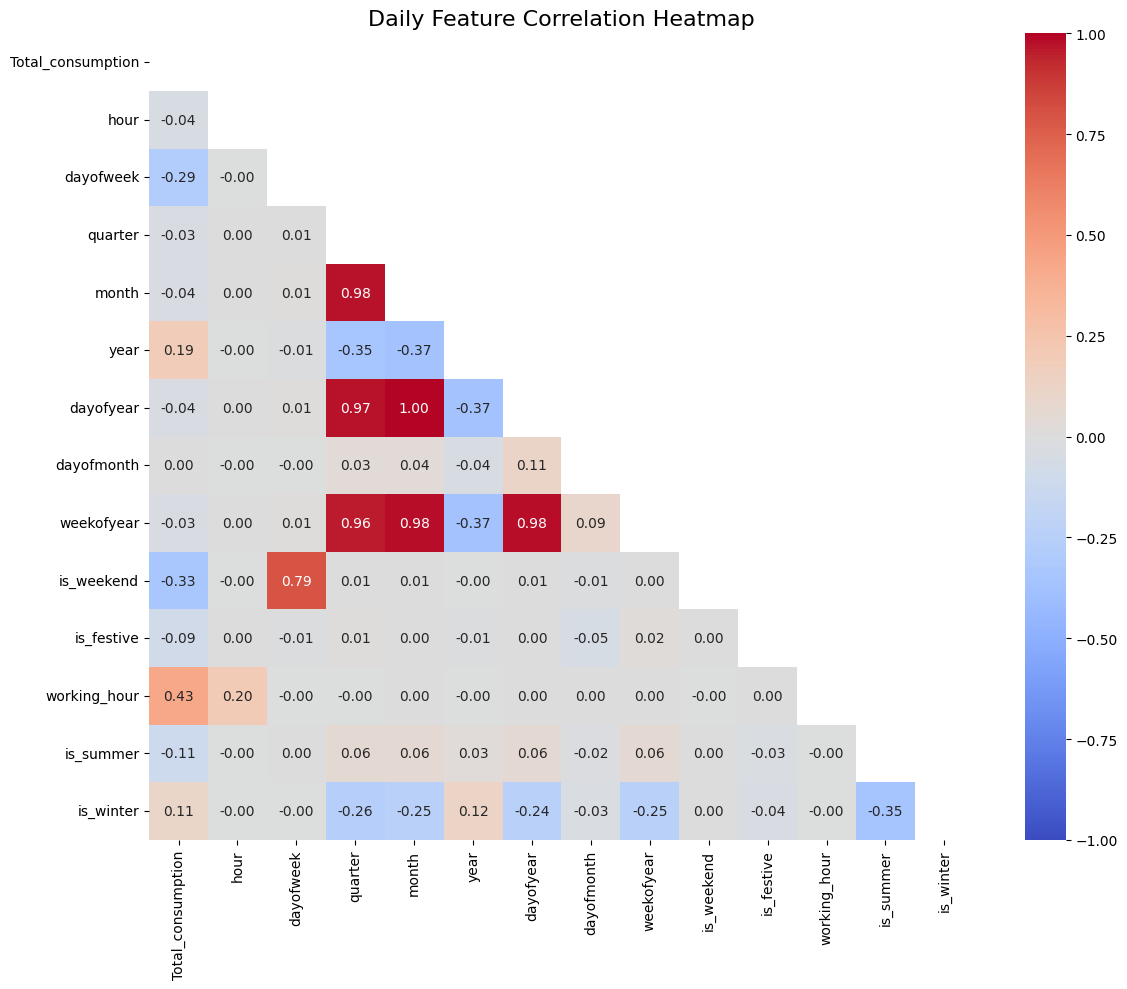

In [25]:
plt.figure(figsize=(12, 10))
numerical_features = df.select_dtypes(include=[np.number]).columns
correlation = df[numerical_features].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, vmin=-1, vmax=1)
plt.title("Daily Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
print("\nBasic Statistics (Total Consumption):")
print(df['Total_consumption'].describe())


Basic Statistics (Total Consumption):
count    19959.000000
mean        20.494159
std         18.626605
min        -16.521100
25%         10.834950
50%         13.089100
75%         22.813400
max        158.735000
Name: Total_consumption, dtype: float64


In [31]:
shift_val = abs(df["Total_consumption"].min()) + 1  
df["log_consumption"] = np.log(df["Total_consumption"] + shift_val)

In [33]:
target = "log_consumption"
y_orig = df["Total_consumption"]

y = df[target]
exog = df[exog_features]

In [34]:
split_index = int(0.80 * len(df))
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
exog_train, exog_test = exog.iloc[:split_index], exog.iloc[split_index:]
y_orig_train, y_orig_test = y_orig.iloc[:split_index], y_orig.iloc[split_index:]

print(f"Training data from {df.index[0].date()} to {df.index[split_index-1].date()}")
print(f"Testing data from {df.index[split_index].date()} to {df.index[-1].date()}")

Training data from 2022-09-28 to 2024-09-06
Testing data from 2024-09-06 to 2025-02-19


In [35]:
# Normalize the exogenous features using training data
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train),
    columns=exog_train.columns,
    index=exog_train.index
)
exog_test_scaled = pd.DataFrame(
    scaler.transform(exog_test),
    columns=exog_test.columns,
    index=exog_test.index
)

In [36]:
print("Finding optimal ARIMA parameters with limited search space...")
try:
    model_auto = auto_arima(
        y_train,
        exogenous=exog_train_scaled,
        seasonal=True,
        m=7,  # Weekly seasonality for daily data
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
        max_order=3,
        max_p=2,
        max_q=2,
        max_d=1,
        max_P=1,
        max_Q=1,
        max_D=1,
        start_p=1,
        start_q=1,
        start_P=1,
        start_Q=1,
        information_criterion='aic',
        maxiter=50,
        method='lbfgs',
        n_jobs=1
    )
    
    order = model_auto.order
    seasonal_order = model_auto.seasonal_order
    
    print("Optimal ARIMA order:", order)
    print("Optimal Seasonal order:", seasonal_order)
    
except Exception as e:
    print(f"Auto ARIMA failed with error: {e}")
    print("Using predefined ARIMA parameters instead...")
    order = (1, 1, 1)
    seasonal_order = (1, 0, 0, 7)

# ---------------------------
# Fit SARIMAX Model with a Constant Trend (Daily)
# ---------------------------
print("\nFitting SARIMAX model...")
try:
    model = SARIMAX(
        y_train,
        exog=exog_train_scaled,
        order=order,
        seasonal_order=seasonal_order,
        trend='c',  # Include a constant trend
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False, maxiter=200, method='lbfgs')
    
    print("\nModel Summary:")
    print(model_fit.summary().tables[0].as_text())
    print(model_fit.summary().tables[1].as_text())
    
    # Forecast on the log-transformed scale
    forecast_obj = model_fit.get_forecast(steps=len(y_test), exog=exog_test_scaled)
    y_pred_log = forecast_obj.predicted_mean
    y_pred_log.index = y_test.index

except MemoryError:
    print("Memory error during SARIMAX fitting. Using a simplified approach...")
    window_size = 2000
    y_pred_log = []
    for i in range(0, len(y_test), window_size):
        end_idx = min(i + window_size, len(y_test))
        subset_train = y_train.iloc[-10000:] if len(y_train) > 10000 else y_train
        subset_exog_train = exog_train_scaled.iloc[-10000:] if len(exog_train_scaled) > 10000 else exog_train_scaled
        
        subset_model = SARIMAX(
            subset_train,
            exog=subset_exog_train,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 0, 7),
            trend='c',
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        subset_fit = subset_model.fit(disp=False, maxiter=100, method='lbfgs')
        subset_pred = subset_fit.get_forecast(
            steps=end_idx - i,
            exog=exog_test_scaled.iloc[i:end_idx]
        )
        y_pred_log.extend(subset_pred.predicted_mean.tolist())
    
    y_pred_log = pd.Series(y_pred_log, index=y_test.index)



Finding optimal ARIMA parameters with limited search space...
Performing stepwise search to minimize aic


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-19901.786, Time=12.01 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-17191.281, Time=0.57 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-19698.202, Time=2.52 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-19603.975, Time=2.87 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-17193.281, Time=0.39 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-19780.996, Time=4.96 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-19780.933, Time=3.86 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-19782.565, Time=3.30 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-19755.751, Time=6.76 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-19816.477, Time=9.71 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=-20176.515, Time=7.84 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=-21302.691, Time=14.57 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=7.36 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=-21102.499, Time=13.95 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=-19826.312, Time=3.29 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-20248.564, Time=17.45 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-19698.233, Time=3.16 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=-19842.139, Time=9.55 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[7]             : AIC=inf, Time=7.21 sec

Best model:  ARIMA(2,1,1)(0,0,1)[7] intercept
Total fit time: 131.415 seconds
Optimal ARIMA order: (2, 1, 1)
Optimal Seasonal order: (0, 0, 1, 7)

Fitting SARIMAX model...


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                   log_consumption   No. Observations:                15967
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 7)   Log Likelihood               10688.659
Date:                           Mon, 10 Mar 2025   AIC                         -21339.318
Time:                                   13:52:34   BIC                         -21193.443
Sample:                                        0   HQIC                        -21291.065
                                         - 15967                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -4.868e-05   1.38e-05     -3.518      0.000   -7.58e-05   -2.16e-05
hour            -0.00

c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [37]:
# ---------------------------
# Invert the Log Transformation (Daily)
# ---------------------------
y_pred = np.exp(y_pred_log) - shift_val

In [39]:
# ---------------------------
# Compute Performance Metrics on Original Scale
# ---------------------------
def calculate_mape(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def calculate_smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred) + 1e-10
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

mae = mean_absolute_error(y_orig_test, y_pred)
mse = mean_squared_error(y_orig_test, y_pred)
rmse = np.sqrt(mse)
mape = calculate_mape(y_orig_test.values, y_pred.values)
smape = calculate_smape(y_orig_test.values, y_pred.values)
r2 = r2_score(y_orig_test, y_pred)

print("\nModel Performance Metrics (Original Scale):")
print(f"MAE:   {mae:.4f}")
print(f"MSE:   {mse:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAPE:  {mape:.4f}%")
print(f"sMAPE: {smape:.4f}%")
print(f"R²:    {r2:.4f}")


Model Performance Metrics (Original Scale):
MAE:   15.9520
MSE:   818.3308
RMSE:  28.6065
MAPE:  95.0646%
sMAPE: 50.7041%
R²:    -0.0793


In [ ]:
# ---------------------------
# Create Forecast DataFrame and Save Predictions (Daily)
# ---------------------------
forecast_df = pd.DataFrame({
    "Real_Consumption_kWh": y_orig_test,
    "Predicted_Consumption_kWh": y_pred
}, index=y_orig_test.index)

forecast_df["Difference"] = forecast_df["Predicted_Consumption_kWh"] - forecast_df["Real_Consumption_kWh"]
forecast_df["Absolute_Error"] = abs(forecast_df["Difference"])
forecast_df["Percent_Error"] = (forecast_df["Absolute_Error"] / (forecast_df["Real_Consumption_kWh"].abs() + 1e-10)) * 100
forecast_df = forecast_df.round(4)
forecast_df.to_csv("results/daily3/predicted_values_kwh.csv")
print("\nPredicted values have been saved to 'results/daily3/predicted_values_kwh.csv'")

AttributeError: 'DataFrame' object has no attribute 'show'

In [42]:
# ---------------------------
# Feature Importance Analysis (Daily)
# ---------------------------
feature_importance = pd.DataFrame({
    'Feature': exog_features,
    'Correlation': [abs(df[feature].corr(df[target])) for feature in exog_features]
})
feature_importance = feature_importance.sort_values('Correlation', ascending=False)
print("\nFeature Importance by Correlation with Target (Log Scale):")
print(feature_importance.head(10))
feature_importance.to_csv("results/daily3/feature_importance.csv", index=False)


Feature Importance by Correlation with Target (Log Scale):
         Feature  Correlation
10  working_hour     0.417299
8     is_weekend     0.396230
1      dayofweek     0.334778
11     is_summer     0.164907
4           year     0.151252
12     is_winter     0.142001
9     is_festive     0.100744
3          month     0.055844
5      dayofyear     0.054532
2        quarter     0.052872


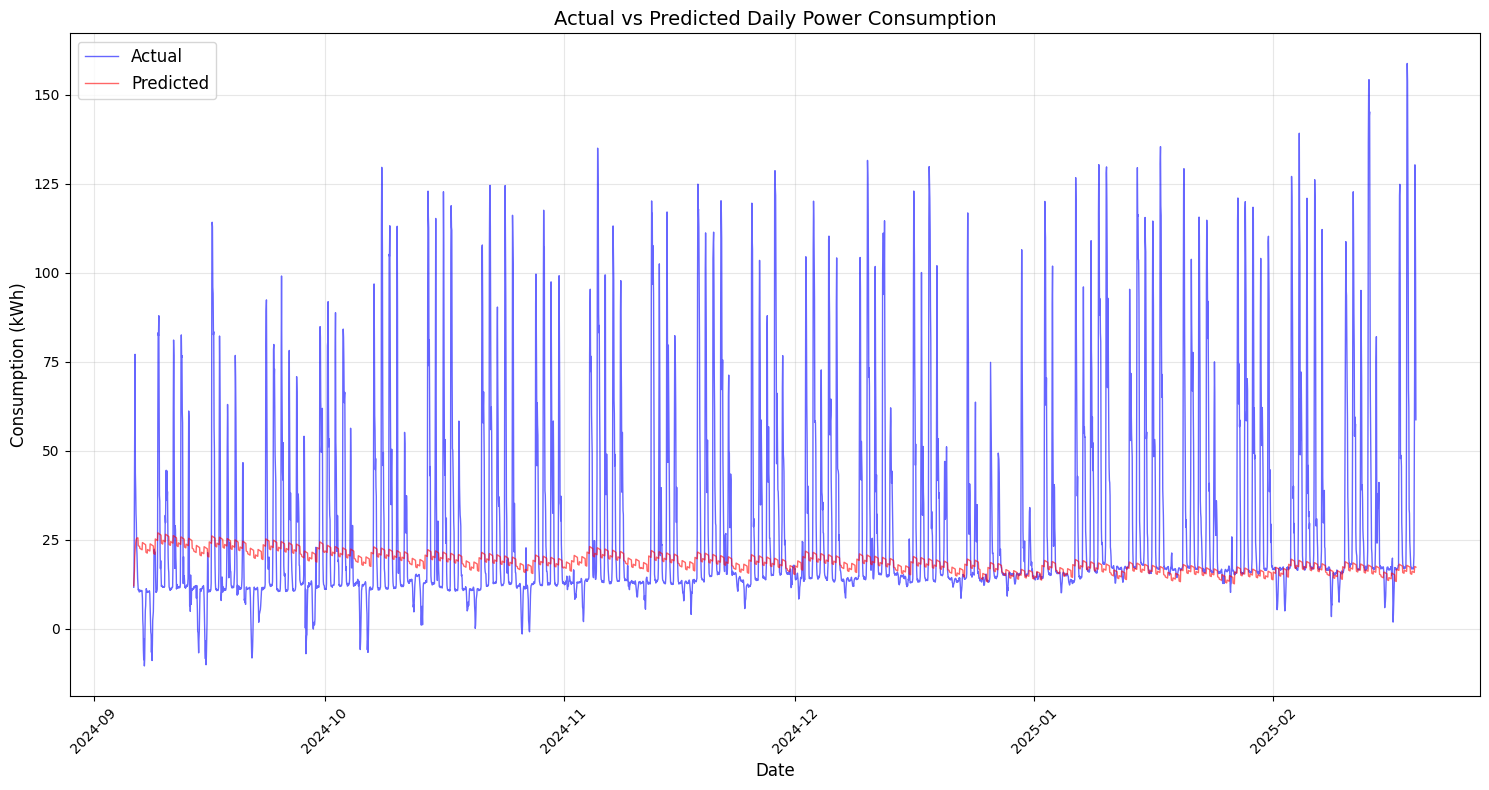

In [43]:
# ---------------------------
# Visualization: Forecast Comparison (Daily)
# ---------------------------
plt.figure(figsize=(15, 8))
plt.plot(forecast_df.index, forecast_df["Real_Consumption_kWh"], label="Actual", color="blue", alpha=0.6, linewidth=1)
plt.plot(forecast_df.index, forecast_df["Predicted_Consumption_kWh"], label="Predicted", color="red", alpha=0.6, linewidth=1)
plt.title("Actual vs Predicted Daily Power Consumption", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Consumption (kWh)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




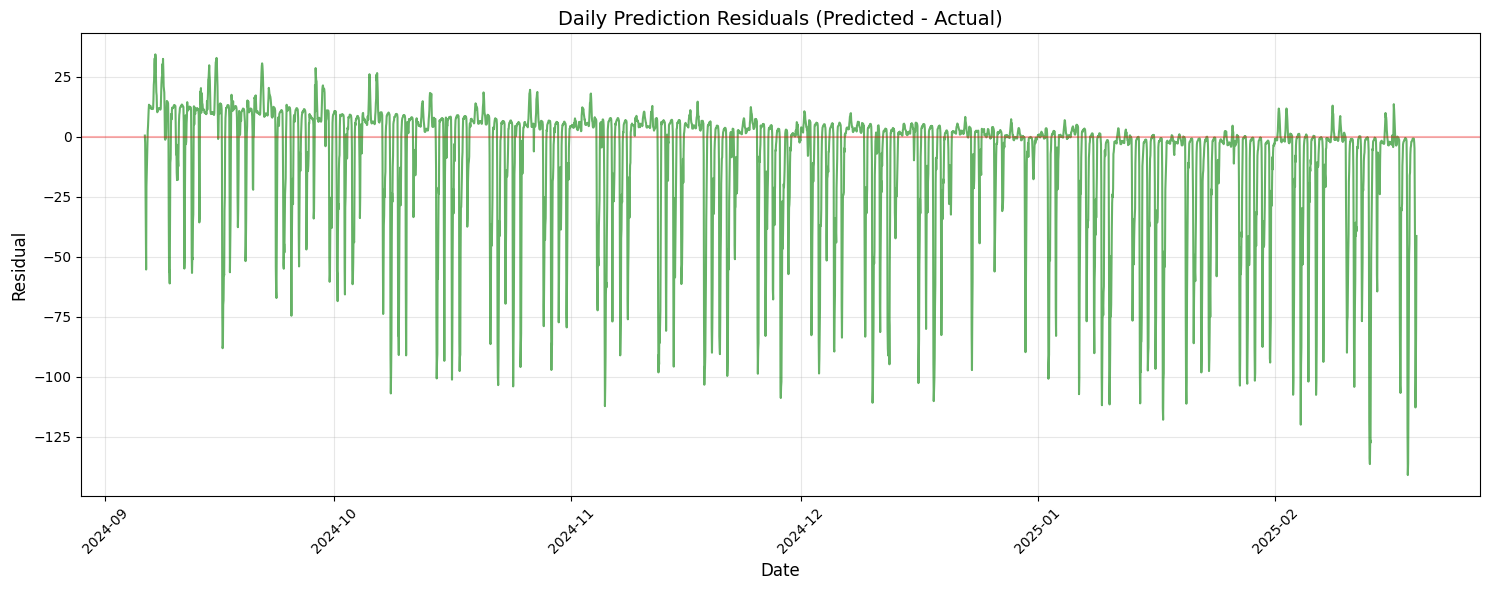

In [44]:
# Plot the residuals
plt.figure(figsize=(15, 6))
plt.plot(forecast_df.index, forecast_df["Difference"], color='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title("Daily Prediction Residuals (Predicted - Actual)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




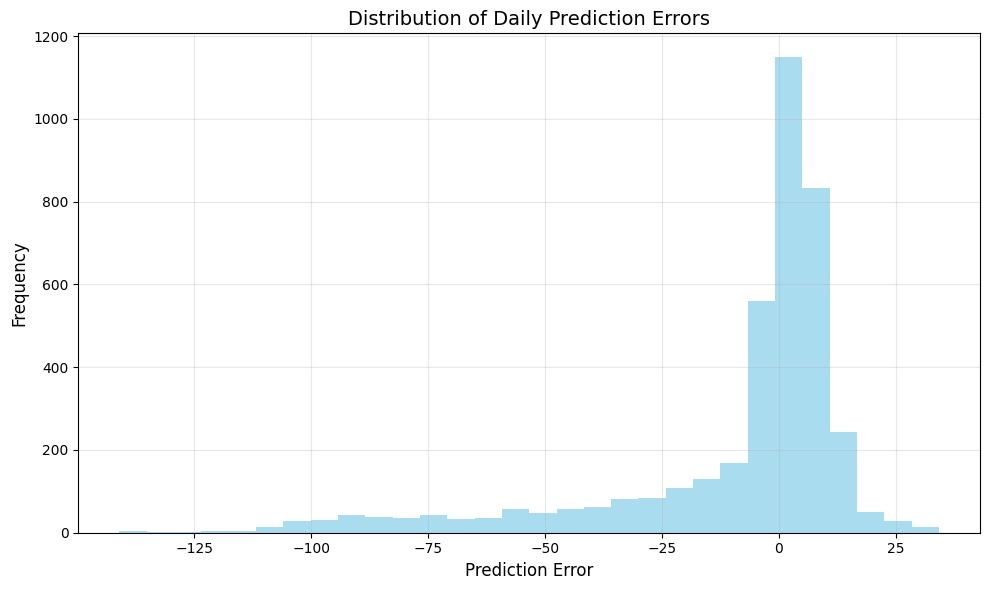

In [45]:
# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(forecast_df["Difference"], bins=30, alpha=0.7, color='skyblue')
plt.title("Distribution of Daily Prediction Errors", fontsize=14)
plt.xlabel("Prediction Error", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




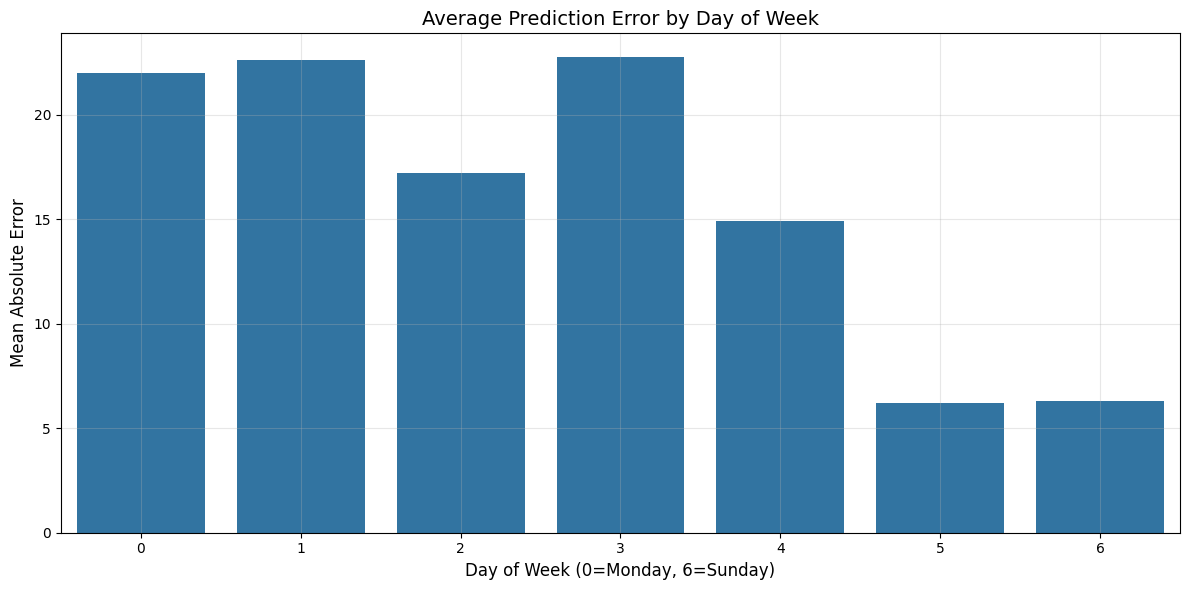


All daily visualizations have been saved in the 'results/daily3' directory.
Daily forecasting analysis complete.


In [46]:
# Remove index name to avoid ambiguity when grouping
forecast_df.index.name = None

# Add additional column for error analysis: day_of_week
forecast_df['Day_of_Week'] = forecast_df.index.dayofweek

# Error by day of week
plt.figure(figsize=(12, 6))
day_error = forecast_df.groupby('Day_of_Week')['Absolute_Error'].mean()
sns.barplot(x=day_error.index, y=day_error.values)
plt.title('Average Prediction Error by Day of Week', fontsize=14)
plt.xlabel('Day of Week (0=Monday, 6=Sunday)', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("\nAll daily visualizations have been saved in the 'results/daily3' directory.")
print("Daily forecasting analysis complete.")



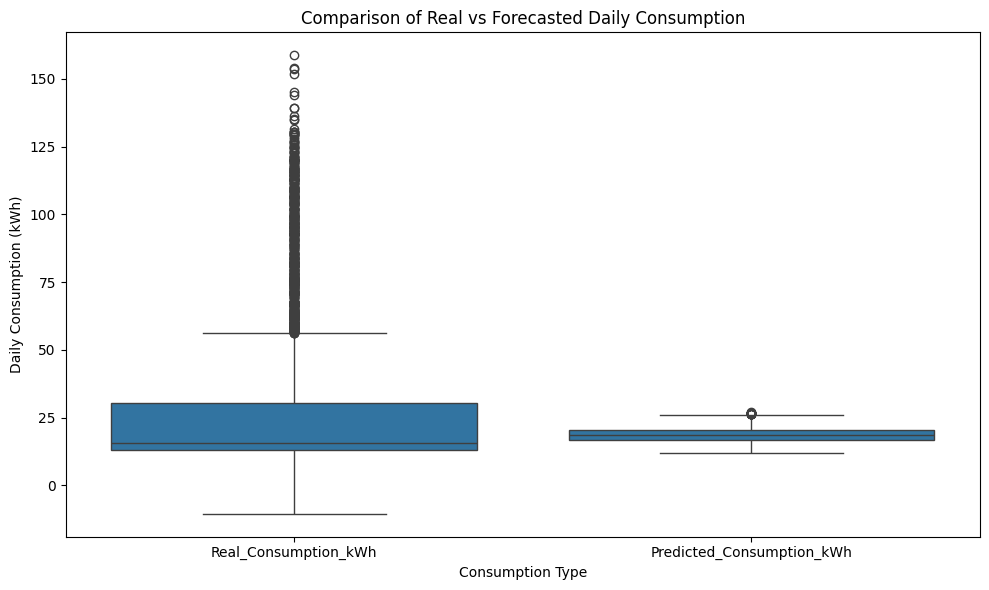

In [47]:
# ---------------------------
# Boxplot: Comparison of Real vs Forecasted Values
# ---------------------------
# Melt the DataFrame to convert it into a long format suitable for a boxplot.
melted_df = forecast_df[['Real_Consumption_kWh', 'Predicted_Consumption_kWh']].reset_index().melt(
    id_vars='index', 
    value_vars=['Real_Consumption_kWh', 'Predicted_Consumption_kWh'],
    var_name='Type',
    value_name='Consumption'
)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Consumption', data=melted_df)
plt.title("Comparison of Real vs Forecasted Daily Consumption")
plt.xlabel("Consumption Type")
plt.ylabel("Daily Consumption (kWh)")
plt.tight_layout()
plt.show()